In [0]:
# mount for our school's unlimited gdrive, so we don't have to download it again
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# changing dirctory for easier work
from os import chdir
chdir("/content/drive/My Drive/wav")

In [0]:
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 
# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
data = pd.read_csv("labels.csv", sep="\t") 
# Preview the first 5 lines of the loaded data 
data.head()

,VoxCeleb1 ID,VGGFace1 ID,Gender,Nationality,Set
0,id10001,A.J._Buckley,m,Ireland,dev
1,id10002,A.R._Rahman,m,India,dev
2,id10003,Aamir_Khan,m,India,dev
3,id10004,Aaron_Tveit,m,USA,dev
4,id10005,Aaron_Yoo,m,USA,dev


In [0]:
!pip install librosa

In [0]:
# we use this for loading all the paths for the wav data
# recursive search in given folders
import os
import glob
cwd = os.getcwd()

dataset = []

i = 0

wavdir = '/content/drive/My Drive/wav/'
for wavfile in glob.glob(wavdir + '**/*.wav', recursive=True):
  setid = wavfile.split(wavdir)[1].split('/')[0]
  i += 1
  gender = data[data['VoxCeleb1 ID'] == setid]['Gender'].values[0]
  dataset.append((wavfile, gender))

In [0]:
import librosa
import numpy as np

In [0]:
# y output
# sr sample rate

# size of feature_set is 2 x 125 x N of total 1375 samples
# first dimension is for fe/male
# rest is cut out (125xN) of the signal from wav and processed by short furier serie transofrmation
# also the stft uses the complex numbers so I'm using abs

feature_set = []

for filename, gender in dataset[:10]:
  y, sr = librosa.load(filename)
  stft = abs(librosa.core.stft(y))
  sr = sr / 100
  # also we can use more feature functions in the future, but it would be a huge overhead for now
  #mfcc = librosa.feature.mfcc(y)
  #spc_flat = librosa.feature.spectral_flatness(y)
  #tmp = (stft/sr)[:125]
  #tmp = np.zeros()
  feature_set.append((gender, (stft/sr)[:125]))


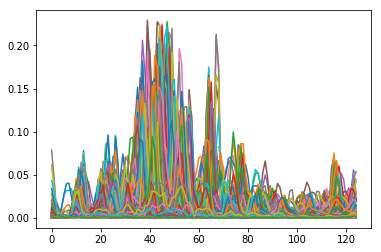

In [0]:
import matplotlib.pyplot as plt
plt.plot(feature_set[1][1])


In [0]:
# import very interesting stuff here...
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# class for neural network two linear elements and one non-linear for the rectifier
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l3(x)
        return F.log_softmax(x)

In [0]:
# tuning values for the neural network
input_size = 150
output_size = 2 # class number
hidden_size = 200

# epoch shouldn't be over 125 x batch_size, it could cause the overfitting
epochs = 50
batch_size = 50
learning_rate = 0.001

In [0]:
# test is network is inicialized correctly
net = Network()
print(net)

Network(
  (l1): Linear(in_features=150, out_features=200, bias=True)
  (relu): ReLU()
  (l3): Linear(in_features=200, out_features=2, bias=True)
)


In [0]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

In [0]:
# male is 1
# female is 0
genderVector = []
for gender, _ in feature_set:
    if gender == "m":
        genderVector.append(1)
    else:
        genderVector.append(0)

# conversion to torch tensor, coz NN process only tensors
genderVector = torch.tensor(genderVector)

In [0]:
# mean of the given matrices to get only one vector of given matrix
# also here we had to cut off to 150 samples only
ft = feature_set[0][1]
inputs = []
for g, ft in feature_set:
    ft = ft.sum(axis=0) / ft.shape[0]
    ft = ft[:150]
    inputs.append(ft)

# just for easier use
inputs = torch.tensor(inputs)
outputs = genderVector

In [0]:
loss_log = []

# training, process for each epoch and batch to make training more _consumables_

for e in range(epochs):
    for i in range(0, len(inputs), batch_size):
        x_mini = inputs[i:i + batch_size] 
        y_mini = outputs[i:i + batch_size] 
        
        x_var = Variable(x_mini)
        y_var = Variable(y_mini)
        
        optimizer.zero_grad()
        net_out = net(x_var)
        
        loss = loss_func(net_out, y_var)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            loss_log.append(loss.data.item())
        
        print('Epoch: {} - Loss: {:.6f}'.format(e, loss.data.item()))

Epoch: 0 - Loss: 0.713256
Epoch: 1 - Loss: 0.712565
Epoch: 2 - Loss: 0.711253
Epoch: 3 - Loss: 0.709385
Epoch: 4 - Loss: 0.707022
Epoch: 5 - Loss: 0.704218
Epoch: 6 - Loss: 0.701024
Epoch: 7 - Loss: 0.697484
Epoch: 8 - Loss: 0.693639
Epoch: 9 - Loss: 0.689528
Epoch: 10 - Loss: 0.685186
Epoch: 11 - Loss: 0.680641
Epoch: 12 - Loss: 0.675919
Epoch: 13 - Loss: 0.671047
Epoch: 14 - Loss: 0.666049
Epoch: 15 - Loss: 0.660946
Epoch: 16 - Loss: 0.655755
Epoch: 17 - Loss: 0.650494
Epoch: 18 - Loss: 0.645179
Epoch: 19 - Loss: 0.639826
Epoch: 20 - Loss: 0.634443
Epoch: 21 - Loss: 0.629041
Epoch: 22 - Loss: 0.623629
Epoch: 23 - Loss: 0.618215
Epoch: 24 - Loss: 0.612809
Epoch: 25 - Loss: 0.607415
Epoch: 26 - Loss: 0.602039
Epoch: 27 - Loss: 0.596689
Epoch: 28 - Loss: 0.591367
Epoch: 29 - Loss: 0.586078
Epoch: 30 - Loss: 0.580823
Epoch: 31 - Loss: 0.575607
Epoch: 32 - Loss: 0.570431
Epoch: 33 - Loss: 0.565298
Epoch: 34 - Loss: 0.560210
Epoch: 35 - Loss: 0.555168
Epoch: 36 - Loss: 0.550173
Epoch: 37 -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
